# Simulate N-of-1 Trial with 1 Moderator Variable and fit different models

In [1]:
import json
from sinot.simulation import Simulation
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd

import pymc as pm
from dataclasses import dataclass
from typing import List
import arviz as az

import numpy as np
from sklearn.linear_model import LinearRegression

In [5]:
# Define constants
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
from numpy.random import default_rng
rng = default_rng()

n_observations = 1000
treatment_window_length = 10
treatment_order = [1,2,1,2]
treatments = np.repeat(treatment_order,n_observations / len(treatment_order))

In [44]:
# Simulation constants
mu_p_true = 1
epsilon_i_sigma_true = 0.1
mu_T_1_true = 10
mu_T_2_true = -5
alpha_T_1_true = 1
alpha_T_2_true = -1

## DAG formula

$ O = \mu_p + \epsilon_i + \mathbb{1}(T_i = \text{active}) (\mu_T + \alpha_{T_i} (c - \mu_c))$

- $\mu_p$ - Population baseline mean
- $\epsilon_i$ - Individual baseline mean
- $\mu_T$ - Average Treatment Effect
- $\alpha_{T_i, c}$ - Moderator Slope for Treatment i and c
- $\mu_c$ - Intercept for c 
- $c$ - Value of covariate c

In [45]:
@dataclass
class Simulation:
    mu_p: float
    epsilon_i: float
    mu_T: List[float]
    alpha_T: List[float]
    c: List[float]
    
    def X(self, treatments):
        return pd.DataFrame({'mu_T_1': (treatments==1), 'mu_T_2': (treatments==2), 'alpha_1': self.c * (treatments==1), 'alpha_2': self.c * (treatments==2)})

In [46]:
simulation = Simulation(**{
'mu_p': mu_p_true,
'epsilon_i': rng.standard_normal(n_observations) * epsilon_i_sigma_true,
'mu_T': [mu_T_1_true, mu_T_2_true],
'alpha_T': [alpha_T_1_true, alpha_T_2_true],
'c': rng.standard_normal(n_observations) * 10,
})
# c already normalized so we do not cover mu_c

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

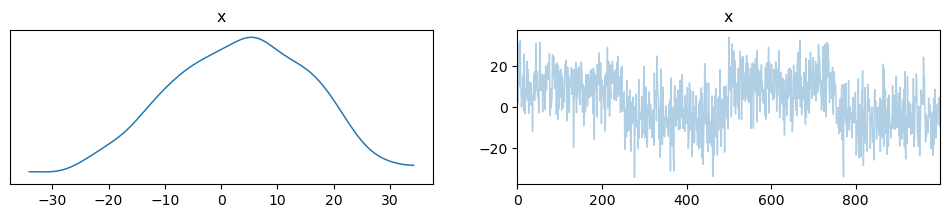

In [47]:
O_observed =(
simulation.mu_p + simulation.epsilon_i
+ ((treatments == 1) * (simulation.mu_T[0] + simulation.alpha_T[0] * simulation.c))
+ ((treatments == 2) * (simulation.mu_T[1] + simulation.alpha_T[1] * simulation.c))
)
az.plot_trace(O_observed)

In [49]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu_p = pm.Normal("mu_p", mu=0, sigma=10)
    
    epsilon_i_sigma = epsilon_i_sigma_true # pm.HalfNormal("epsilon_i_sigma", sigma=10)
    
    mu_T = pm.Normal("mu_T", mu=0, sigma=10, shape=2)
    
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=2)
    
    O = pm.Normal("O", mu=(mu_p + ((treatments==1) * (mu_T[0] + alpha[0] * simulation.c)) + ((treatments==2) * (mu_T[1] + alpha[1] * simulation.c))), sigma=epsilon_i_sigma, observed=O_observed)
    

In [50]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_p, mu_T, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree dep

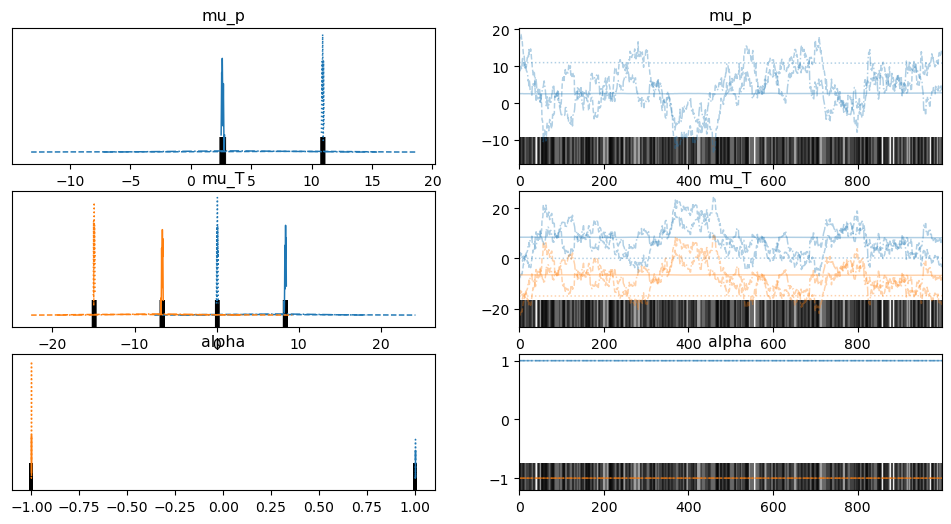

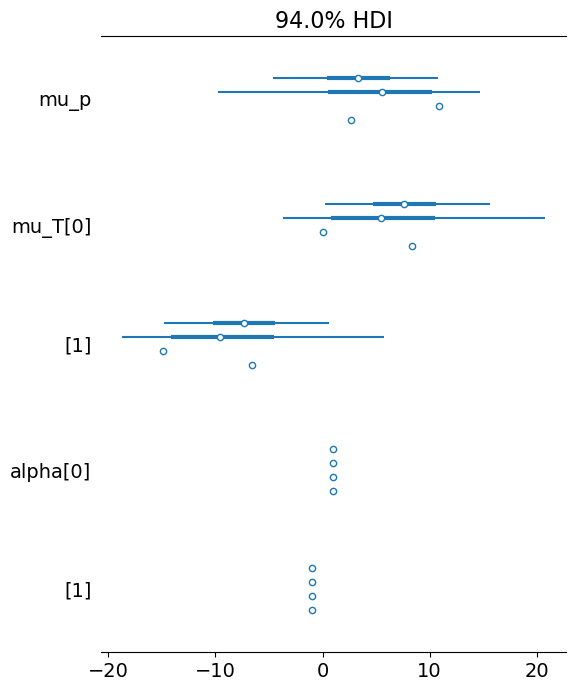

In [51]:
with model:
    az.plot_trace(trace)
    az.plot_forest(trace)

In [ ]:
with model:
    az.plot_density(trace)

In [ ]:
trace

In [48]:
X = simulation.X(treatments)
reg = LinearRegression().fit(X, O_observed)

print(reg.score(X, y))

print(reg.coef_)

print(reg.intercept_)



-0.6887580422698545
[ 7.50136393 -7.50136393  1.00073265 -0.9997986 ]
3.4997427972990227


In [31]:
X

,alpha_1,alpha_2
0,14.418041,0.000000
1,-2.999130,-0.000000
2,5.608334,0.000000
3,1.035985,0.000000
4,0.516410,0.000000
...,...,...
995,0.000000,2.241991
996,-0.000000,-5.960802
997,-0.000000,-9.313629
998,0.000000,6.033978
